Import libraries

In [4]:
import joblib
import warnings

import numpy  as np
import pandas  as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy   import stats

from IPython.display      import Image
from IPython.core.display import HTML

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

Data Import and description

In [6]:
df1 = pd.read_csv('/content/fraud_0.1origbase.csv')

In [7]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0.0,0.0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0.0,0.0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0.0,0.0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0.0,0.0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0.0,0.0


In [11]:
!pip install inflection

import inflection

cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216746 entries, 0 to 216745
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              216746 non-null  int64  
 1   type              216746 non-null  object 
 2   amount            216746 non-null  float64
 3   name_orig         216745 non-null  object 
 4   oldbalance_org    216745 non-null  float64
 5   newbalance_orig   216745 non-null  float64
 6   name_dest         216745 non-null  object 
 7   oldbalance_dest   216745 non-null  float64
 8   newbalance_dest   216745 non-null  float64
 9   is_fraud          216745 non-null  float64
 10  is_flagged_fraud  216745 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 18.2+ MB


Data Cleaning

In [13]:
df1.isna().mean()

,0
step,0.000000
type,0.000000
amount,0.000000
name_orig,0.000005
oldbalance_org,0.000005
newbalance_orig,0.000005
name_dest,0.000005
oldbalance_dest,0.000005
newbalance_dest,0.000005
is_fraud,0.000005


In [17]:
# Handle missing values
df1['name_orig'] = df1['name_orig'].fillna(0).astype(str).apply(lambda i: i[0])
df1['name_dest'] = df1['name_dest'].fillna(0).astype(str).apply(lambda i: i[0])


In [20]:
df1['is_fraud'] = df1['is_fraud'].map({1: 'yes', 0: 'no'})
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'})

Feature engineering

In [21]:
df2 = df1.copy()

In [22]:
# step
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']

# name orig and name dest
df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])

Expolatory data analysis

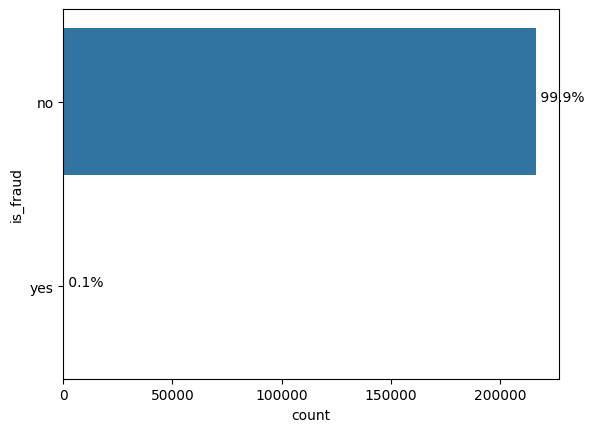

In [25]:
ax = sns.countplot(y='is_fraud', data=df2);

total = df2['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

<Axes: xlabel='amount', ylabel='Density'>

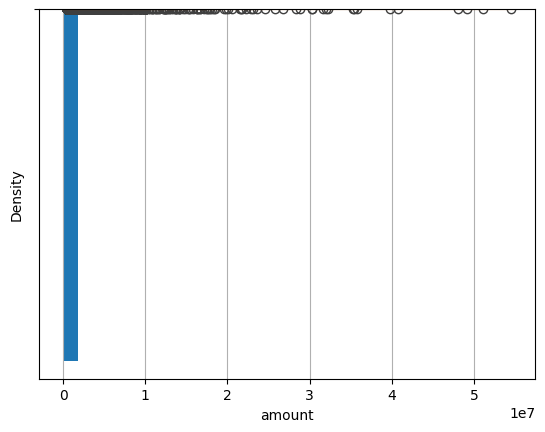

In [27]:
df2['amount'].hist(bins=30)
sns.boxplot(x=df2['amount'])
sns.kdeplot(df2['amount'])

<Axes: xlabel='type', ylabel='count'>

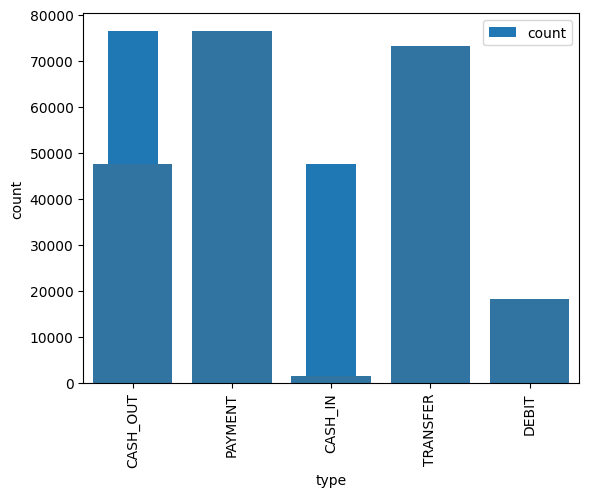

In [29]:
df2['type'].value_counts().plot(kind='bar')
sns.countplot(x='type', data=df2)


<Axes: xlabel='is_fraud', ylabel='amount'>

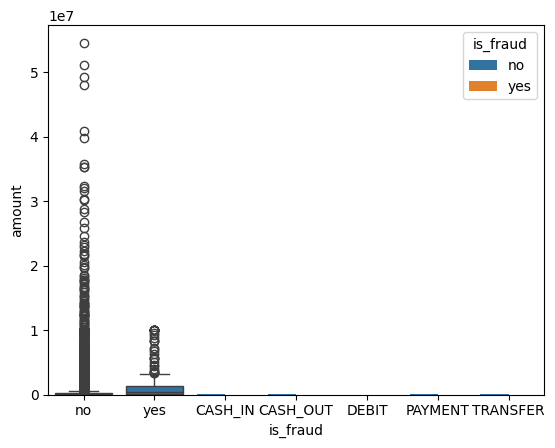

In [32]:
sns.boxplot(x='is_fraud', y='amount', data=df2)
sns.countplot(x='type', hue='is_fraud', data=df2)


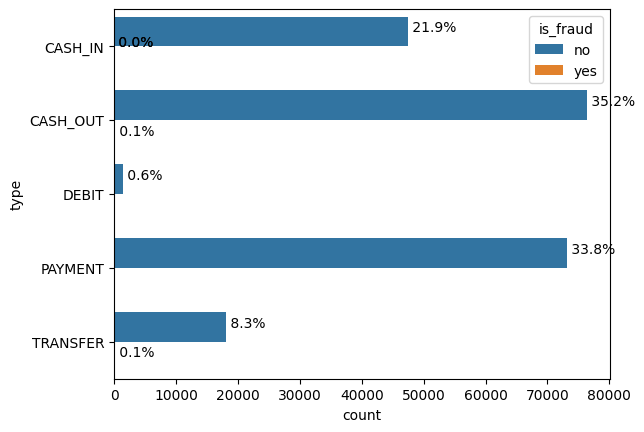

In [34]:
ax = sns.countplot(y='type', hue='is_fraud', data=df2)

total = df2['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))


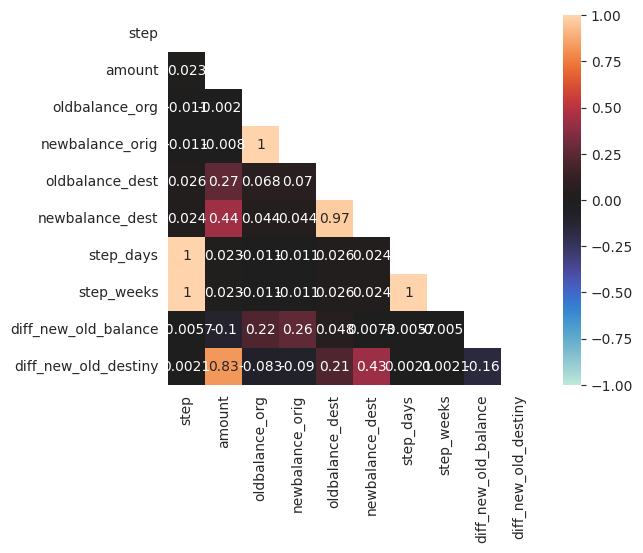

In [36]:
num_attributes = df2.select_dtypes(exclude='object')
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

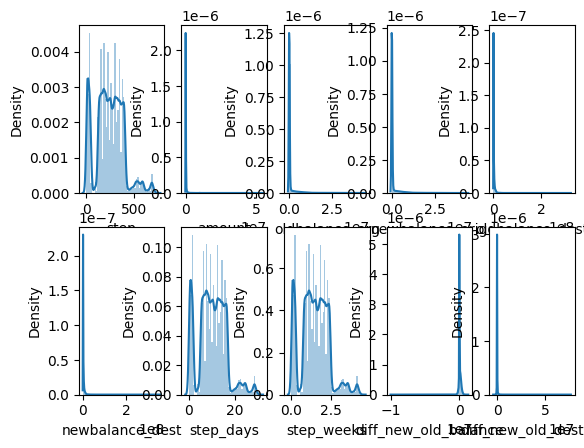

In [76]:
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 5, j)
    sns.distplot(num_attributes[column]);

    j += 1

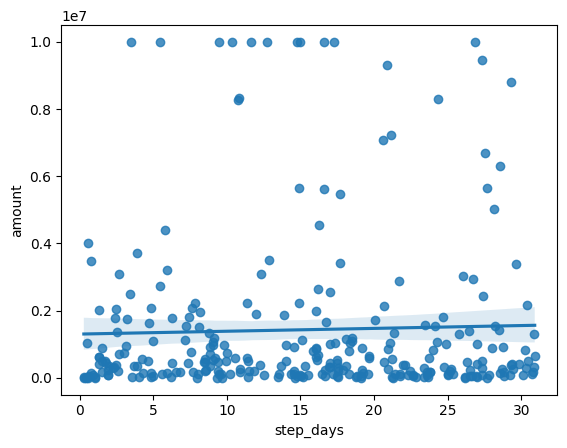

In [80]:
aux1 = df2[df2['is_fraud'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1);

Data Preparation

In [38]:
X = df2.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest',
                      'step_weeks', 'step_days'], axis=1)
y = df2['is_fraud'].map({'yes': 1, 'no': 0})

In [54]:
print(y.isna().sum())
print(X.isna().sum())
y = y.fillna(0)
X = X.fillna(0)

0
step                    0
type                    0
amount                  0
oldbalance_org          1
newbalance_orig         1
oldbalance_dest         1
newbalance_dest         1
diff_new_old_balance    1
diff_new_old_destiny    1
dtype: int64


In [55]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

In [56]:
!pip install category_encoders
from category_encoders import OneHotEncoder

ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

In [57]:
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

In [58]:
final_columns_selected = ['step', 'oldbalance_org',
                          'newbalance_orig', 'newbalance_dest',
                          'diff_new_old_balance', 'diff_new_old_destiny',
                          'type_TRANSFER']

In [59]:
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

**Machine learning modeling**

In [ ]:
#SVM

In [62]:
def ml_scores(model_name, y_true, y_pred):

    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3),
                         'Precision': np.round(precision, 3),
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)},
                        index=[model_name])

In [63]:
svm = SVC()
svm.fit(X_train_cs, y_train)

y_pred = svm.predict(X_valid_cs)

In [64]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5,0.0,0.0,0.0,0.0


In [65]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     34634
         1.0       0.00      0.00      0.00        46

    accuracy                           1.00     34680
   macro avg       0.50      0.50      0.50     34680
weighted avg       1.00      1.00      1.00     34680



In [ ]:
#Logistic regression

In [66]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

In [67]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.5,0.0,0.0,0.0,0.0


In [68]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     34634
         1.0       0.00      0.00      0.00        46

    accuracy                           1.00     34680
   macro avg       0.50      0.50      0.50     34680
weighted avg       1.00      1.00      1.00     34680



In [ ]:
#Random forest

In [69]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [70]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.859,1.0,0.717,0.835,0.835


In [71]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     34634
         1.0       1.00      0.72      0.84        46

    accuracy                           1.00     34680
   macro avg       1.00      0.86      0.92     34680
weighted avg       1.00      1.00      1.00     34680



Compare results

In [73]:
modeling_performance = pd.concat([lg_results, rf_results,svm_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.500,0.0,0.000,0.000,0.000
SVM,0.500,0.0,0.000,0.000,0.000
Random Forest,0.859,1.0,0.717,0.835,0.835
